# NHDPlus and Flow Accumulation

In [1]:
from pynhd import NLDI, WaterData
import pynhd as nhd
import cmocean.cm as cmo
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

[PyNHD](https://github.com/cheginit/pynhd) provides access to the Hydro Network-Linked Data Index ([NLDI](https://labs.waterdata.usgs.gov/about-nldi/index.html)) and the [WaterData](https://labs.waterdata.usgs.gov/geoserver/web/wicket/bookmarkable/org.geoserver.web.demo.MapPreviewPage?1) web services for navigating and subsetting [NHDPlus](https://nhdplus.com/NHDPlus) V2 database.

First, let's get the watershed geometry of the contributing basin of a USGS station using `NLDI`:

In [3]:
nldi = NLDI()
station_id = "USGS-01031500"
ut = "upstreamTributaries"
um = "upstreamMain"

basin = nldi.getfeature_byid("nwissite", station_id, basin=True)

The `navigate_byid` class method can be used to navigate NHDPlus in both upstream and downstream of any point in the database. The available feature sources are ``comid``, ``huc12pp``, ``nwissite``, ``wade``, ``wqp``. Let's get ComIDs and flowlines of the tributaries and the main river channel in the upstream of the station.

In [4]:
args = {
    "fsource": "nwissite",
    "fid": station_id,
    "navigation": um,
    "source": "flowlines",
    "distance": 1000,
}

flw_main = nldi.navigate_byid(**args)

args["navigation"] = ut
flw_trib = nldi.navigate_byid(**args)

We can get other USGS stations upstream (or downstream) of the station and even set a distance limit (in km):

In [5]:
args.update({
    "source" : "nwissite",
})
st_all = nldi.navigate_byid(**args)

args.update({
    "distance": 20,
    "source" : "nwissite",
})
st_d20 = nldi.navigate_byid(**args)

Now, let's get the [HUC12 pour points](https://www.sciencebase.gov/catalog/item/5762b664e4b07657d19a71ea):

In [6]:
args.update({
    "distance": 1000,
    "source" : "huc12pp",
})
pp = nldi.navigate_byid(**args)

Let's plot the vector data:

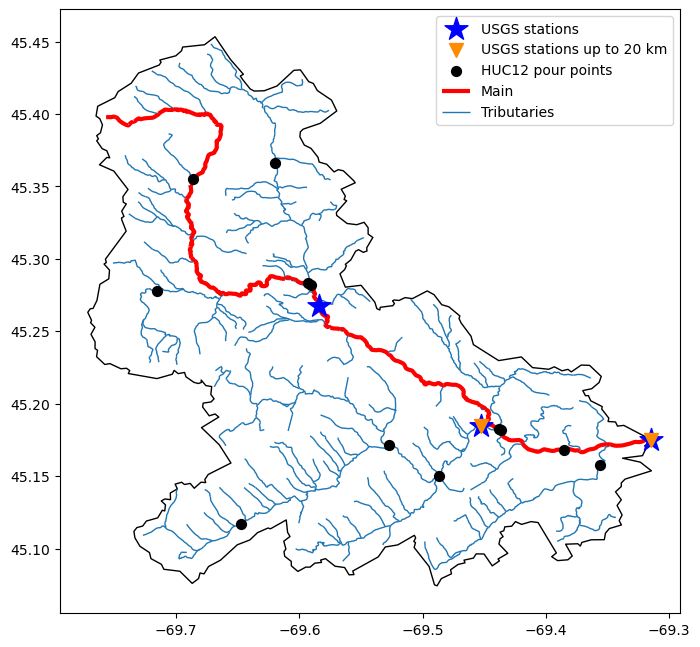

In [19]:
ax = basin.plot(facecolor="none", edgecolor="k", figsize=(8,8))
st_all.plot(ax=ax, label="USGS stations", marker="*", markersize=300, zorder=4, color="b")
st_d20.plot(ax=ax, label="USGS stations up to 20 km", marker="v", markersize=100, zorder=5, color="darkorange")
pp.plot(ax=ax, label="HUC12 pour points", marker="o", markersize=50, color="k", zorder=3)
flw_main.plot(ax=ax, lw=3, color="r", zorder=2, label="Main")
flw_trib.plot(ax=ax, lw=1, zorder=1, label="Tributaries")
ax.legend(loc="best")
ax.set_aspect("auto")
ax.figure.set_dpi(100)

Based on a topological sorted river network ``pynhd.vector_accumulation`` computes flow accumulation in the network. It returns a dataframe which is sorted from upstream to downstream that shows the accumulated flow in each node.

PyNHD has a utility called ``prepare_nhdplus`` that identifies such relationship among other things such as fixing some common issues with NHDPlus flowlines. But first we need to get all the NHDPlus attributes for each ComID since `NLDI` only provides the flowlines' geometries and ComIDs which is useful for navigating the vector river network data. For getting the NHDPlus database we use ``WaterData``. The WaterData web service layers are  ``nhdflowline_network``, ``nhdarea``, ``nhdwaterbody``, ``catchmentsp``, ``gagesii``, ``huc08``, ``huc12``, ``huc12agg``, and ``huc12all``. Let's use the ``nhdflowline_network`` layer to get required info.

In [8]:
wd = WaterData("nhdflowline_network")

comids = flw_trib.nhdplus_comid.to_list()
nhdp_trib = wd.byid("comid", comids)
flw = nhd.prepare_nhdplus(nhdp_trib, 0, 0, purge_non_dendritic=False)

The NLDI service offers about 140 NHDPlus catchment-scale attributes that are associated with ComIDs. Let's get Mean Annual Groundwater Recharge using ``getcharacteristic_byid`` class method and carry out with the flow accumulation.

In [9]:
char = "CAT_RECHG"
area = "areasqkm"

local = nldi.getcharacteristic_byid(comids, "local", char_ids=char)
flw = flw.merge(local[char], left_on="comid", right_index=True)

def runoff_acc(qin, q, a):
    return qin + q * a

flw_r = flw[["comid", "tocomid", char, area]]
runoff = nhd.vector_accumulation(flw_r, runoff_acc, char, [char, area])

def area_acc(ain, a):
    return ain + a

flw_a = flw[["comid", "tocomid", area]]
areasqkm = nhd.vector_accumulation(flw_a, area_acc, area, [area])

runoff /= areasqkm

Since these are catchment-scale characteristic, let's get the catchments then add the accumulated characteristic as a new column and plot the results.

In [10]:
wd = WaterData("catchmentsp")
catchments = wd.byid("featureid", comids)

c_local = catchments.merge(local, left_on="featureid", right_index=True)
c_acc = catchments.merge(runoff, left_on="featureid", right_index=True)

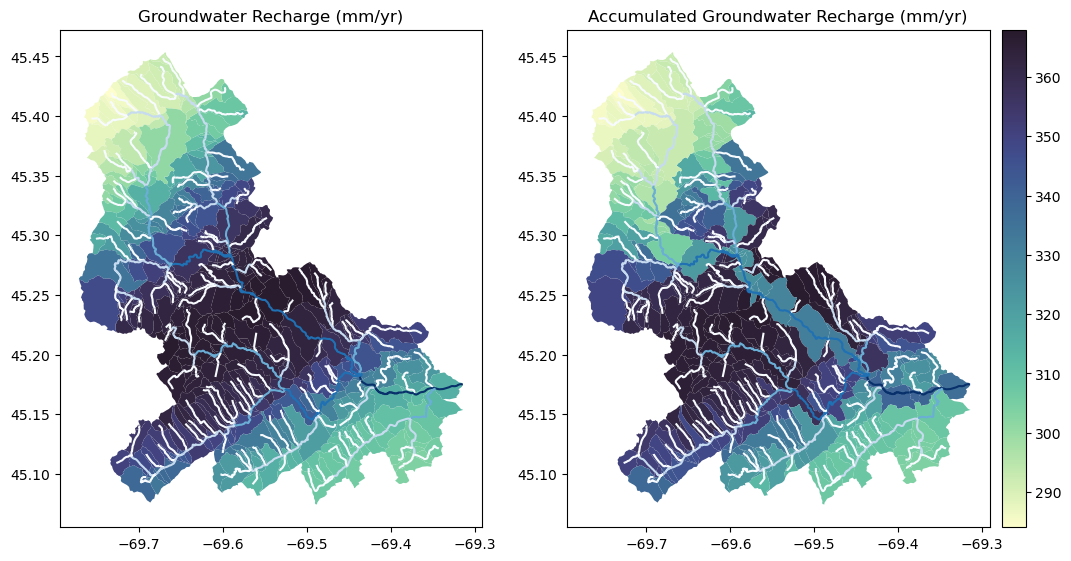

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8), dpi=100)

cmap = cmo.deep
norm = plt.Normalize(vmin=c_local.CAT_RECHG.min(), vmax=c_acc.acc_CAT_RECHG.max())

c_local.plot(ax=ax1, column=char, cmap=cmap, norm=norm)
flw.plot(ax=ax1, column="streamorde", cmap="Blues", scheme='fisher_jenks')
ax1.set_title("Groundwater Recharge (mm/yr)");

c_acc.plot(ax=ax2, column=f"acc_{char}", cmap=cmap, norm=norm)
flw.plot(ax=ax2, column="streamorde", cmap="Blues", scheme='fisher_jenks')
ax2.set_title("Accumulated Groundwater Recharge (mm/yr)")

cax = fig.add_axes([
    ax2.get_position().x1 + 0.01,
    ax2.get_position().y0,
    0.02,
    ax2.get_position().height
])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
fig.colorbar(sm, cax=cax);